## Caso 2D: Falla a lo largo de Chile Central

Implementando el teorema de Karhunen-Loeve, en este, caso a una matriz de correlación que estará compuesta por:
### $C_{ij}=exp(-(d_{strike}(i,j)/r_{strike})-(d_{dip}(i,j)/r_{dip}))  $

En dónde $d_{strike}(i,j)$ y $d_{dip}(i,j)$ son estimados de la distancia entre subfallas i y j en el strike y dip respectivamente, y $r_{strike}$ y r_{dip} son los largos de correlación en cada dirección.

Se define $d_{dip}(i,j)$ usando la diferencia en profundidad entre dos subfallas y el angulo de dip como

$d_{dip}(i,j)=d_{depth}/sin(dip)$. Configurando $d_{strike}=\sqrt{d_{ij}^2-d_{dip}(i,j)^2}$

Los largo de correlación serán el 40% del largo y ancho de la falla.

## Datos de la falla:
Largo = 500 km
Ancho = 200 km

In [68]:
import geostochpy
import numpy as np
import matplotlib.pyplot as plt
import pygmt

Se ingresan las cantidades de subfallas, a lo largo del dip y a lo largo del strike, nx y ny

In [73]:
def distribucion_slip(C, mu, N):
    from scipy import linalg as la
    """
    Calcula la distribucion de slip con la expansion de karhunen-loeve log-normal
    exp(mu)exp(sum(zk*sqrt(lambdak)*vk))
    Entradas: 
    C: matriz de covarianza, se le calculan los eigenvalues y vectors
    mu: matriz con medias
    N: numero de modos a contar para la sumatoria
    """

    n_cols_cova = np.shape(C)[0]  # C es una matriz cuadrada de dim x dim 
    dim_mu = np.shape(mu)  # dimensiones de mu, para volver a rearmar matriz de slip
    mu = np.reshape(mu, (n_cols_cova,))  # reshaping mu

    # se calculan los valores y vectores propios de la matriz de covarianza
    eig_val, eig_vecs = la.eigh(C)
    eig_val = eig_val.real  # valores propios (lambda_k)
    eig_vecs = eig_vecs.real  # vectores propios (v_k) (columnas de eig_vecs)

    z = np.random.normal(0, 1, n_cols_cova)  # distribucion gaussiana aleatoria z~N(0,1)

    # Cálculo vectorizado del array de slip
    sqrt_eig_val = np.sqrt(np.abs(eig_val[:N]))
    S = np.exp(mu) * np.exp(np.sum(z[:N] * sqrt_eig_val * eig_vecs[:, :N], axis=1))

    # Reshape final para volver a la dimensión original de mu
    S = np.reshape(S, dim_mu)
    return S
nx=40
ny=80
Mw=9.0
width=180
length=500
dx_meters=width/nx*1000
dy_meters=length/ny*1000
print(f'largo subfalla: {dy_meters} m\n ancho subfalla: {dx_meters} m')

largo subfalla: 6250.0 m
 ancho subfalla: 4500.0 m


Primero, se cargarán lo datos del trench de Chile, para realizar una geometría paralela a ella

También, se cargarán los archivos de Slab2, que contienen los parámetros geométricos de la zona de subducción de Sudamérica

In [74]:
route_trench = geostochpy.get_data('trench-chile.txt')
lonsfosa, latsfosa,strikefosa  = geostochpy.load_trench(route_trench)
slabdep,slabdip,slabstrike,slabrake=geostochpy.load_files_slab2(zone='south_america',rake=True)

Se realiza la falla a lo largo del trench, y se le da el valor más al norte de la falla. 

Luego, se deben tener las profundidades en cada subfalla, para ello se interpolan los datos de Slab2 con geostochpy.interp_slabtofault

In [75]:
north=-29.5
lon,lat,lon_flat,lat_flat=geostochpy.make_fault_alongstriketrench(lonsfosa, latsfosa,strikefosa,north, nx, ny, width, length)
X_grid,Y_grid,dep,dip,strike,rake=geostochpy.interp_slabtofault(lon_flat,lat_flat,nx,ny,slabdep,slabdip,slabstrike,slabrake)


##### Se crea la matriz de slips medios con geostochpy.matriz_media(mean,dep)

In [76]:
from scipy.special import kv
def von_karman_correlation(r, H):
    return (r ** H) * kv(H, r)

# Calculo matriz de covarianza usando VK-ACF
def matriz_covarianza_von_karman(dip, prof, lons, lats,length_fault,width_fault, H=0.5):
    """
    Calcula la matriz de correlación utilizando la función von Karman.
    """
    # Vectorizar cálculos
    vector_dip, vector_prof, vector_lon, vector_lat = dip.flatten(), prof.flatten(), lons.flatten(), lats.flatten()
    
    # Calculo de ddip
    ddip = (vector_prof[:, np.newaxis] - vector_prof) / np.sin(np.deg2rad((vector_dip[:, np.newaxis] + vector_dip) / 2))
    ddip = np.nan_to_num(ddip, nan=0.0, posinf=0.0, neginf=0.0)
    
    # Calculo de d
    d = dist_haversine(vector_lon, vector_lon[:, np.newaxis], vector_lat, vector_lat[:, np.newaxis])
    dstrike = np.sqrt(np.abs(d**2 - ddip**2))
    # Calculo de r_ij
    a_s=17.7+0.35*length_fault
    a_d=6.7+0.41*width_fault
    r_ij = np.sqrt((dstrike / a_s) ** 2 + (ddip / a_d) ** 2)/1000 # en km
    # Calculo de Cij usando la función von Karman
    C = np.where(r_ij!=0,von_karman_correlation(r_ij, H) / von_karman_correlation(1e-10,H),1)   
    # Matriz de covarianza
    mat_cova = np.log(C + 1)
    
    return C,mat_cova,r_ij

def dist_haversine(lon1, lon2, lat1, lat2):
    # Convertir grados a radianes
    lon1, lon2, lat1, lat2 = np.radians(lon1), np.radians(lon2), np.radians(lat1), np.radians(lat2)

    # Diferencias en longitudes y latitudes
    dlon = lon2 - lon1
    dlat = lat2 - lat1

    # Fórmula de Haversine
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))

    # Radio de la Tierra en metros (aproximación para latitudes medias)
    radius = 6371000

    # Distancia en metros
    distance = radius * c

    return distance

/tmp/ipykernel_57385/1600680467.py:3: RuntimeWarning: invalid value encountered in multiply
  return (r ** H) * kv(H, r)


NameError: name 'la' is not defined

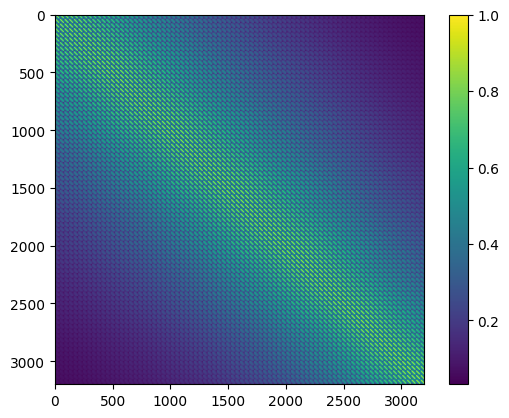

In [77]:
media,rigidez_media=geostochpy.media_slip(Mw,dy_meters,dx_meters,dep)
leveque_taper=geostochpy.taper_LeVeque(dep,60000)
# leveque_taper=leveque_taper/np.max(leveque_taper)
villarroel_taper=geostochpy.taper_except_trench_tukey(dep,alpha_dip=0.3,alpha_strike=0.3)
taper=leveque_taper*villarroel_taper
# taper=geostochpy.taper_except_trench_tukey(dep,alpha_dip=0.6,alpha_strike=0.4,dip_taperfunc=geostochpy.taper_LeVeque,strike_taperfunc=geostochpy.tukey_window_equal)

mu = geostochpy.matriz_medias_villarroel(media,taper)
C,mat_cova,r_ij=matriz_covarianza_von_karman(dip, dep, lon, lat,length,width)
# Encuentra los NaNs en la matriz C
# Imprime los índices de los NaNs
plt.imshow(C)
plt.colorbar()
mat_cova[np.isnan(mat_cova)] = 0
Slip=distribucion_slip(C, mu, 899)
Slip,rigidez,Mo_original,Mo_deseado=geostochpy.escalar_magnitud_momento(Mw, Slip, dep, dy_meters,dx_meters,prem=True)


/home/alex/miniforge3/envs/geostochpy/lib/python3.11/site-packages/geostochpy-0.1-py3.11.egg/geostochpy/__init__.py:699: RuntimeWarning: invalid value encountered in multiply
  return (r ** H) * kv(H, r)


0.009644528559821248 vs 8.24894653430933


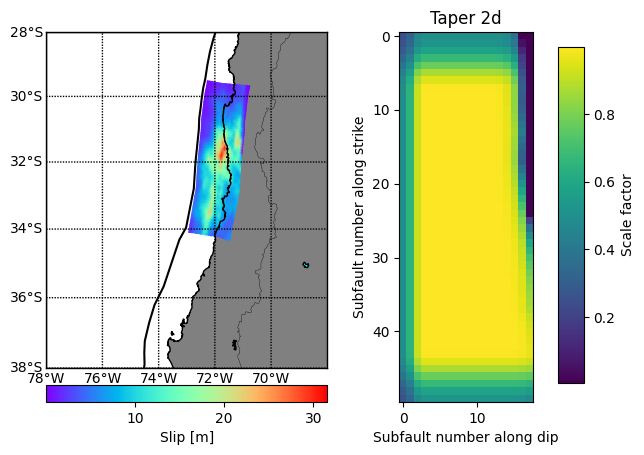

In [12]:

## Creation slip models
# mean matrix
#
media,rigidez_media=geostochpy.media_slip(Mw,dy_meters,dx_meters,dep)
leveque_taper=geostochpy.taper_LeVeque(dep,60000)
# leveque_taper=leveque_taper/np.max(leveque_taper)
villarroel_taper=geostochpy.taper_except_trench_tukey(dep,alpha_dip=0.3,alpha_strike=0.3)
taper=leveque_taper*villarroel_taper
# taper=geostochpy.taper_except_trench_tukey(dep,alpha_dip=0.6,alpha_strike=0.4,dip_taperfunc=geostochpy.taper_LeVeque,strike_taperfunc=geostochpy.tukey_window_equal)

mu = geostochpy.matriz_medias_villarroel(media,taper)
# matriz de covarianza
C    = geostochpy.matriz_covarianza_von_karman(dip, dep, X_grid, Y_grid,length,width)
# for comcot simulation
Slip=geostochpy.distribucion_slip(C, mu, 899)
Slip,rigidez,Mo_original,Mo_deseado=geostochpy.escalar_magnitud_momento(Mw, Slip, dep, dy_meters,dx_meters,prem=True) # se escala el Slip a la magnitud deseada <--------- Slip final
# Hypocenter=geostochpy.hypocenter(X_grid,Y_grid,dep,length,width) se tiene en cuenta la rigidez con el modelo PREM incluido @fetched with Rockhound
# PLOT result
fig=geostochpy.plot_slip(X_grid,Y_grid,lonsfosa,latsfosa,Slip,None,show=True)
ax2=fig.add_subplot(122)
im2=ax2.imshow(taper)
ax2.set_title('Taper 2d')
ax2.set_xlabel('Subfault number along dip')
ax2.set_ylabel('Subfault number along strike')
# add space for colour bar
fig.subplots_adjust(left=-0.5, right=1.1)
cbar_ax = fig.add_axes([0.88, 0.15, 0.04, 0.7])
print(f'{media} vs {np.mean(Slip)}')
fig.colorbar(im2, cax=cbar_ax,label='Scale factor')
fig.savefig('taper2d.png',dpi=300)

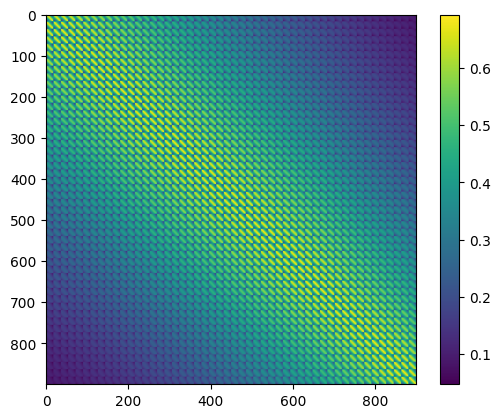

In [8]:
plt.imshow(C)
plt.colorbar()

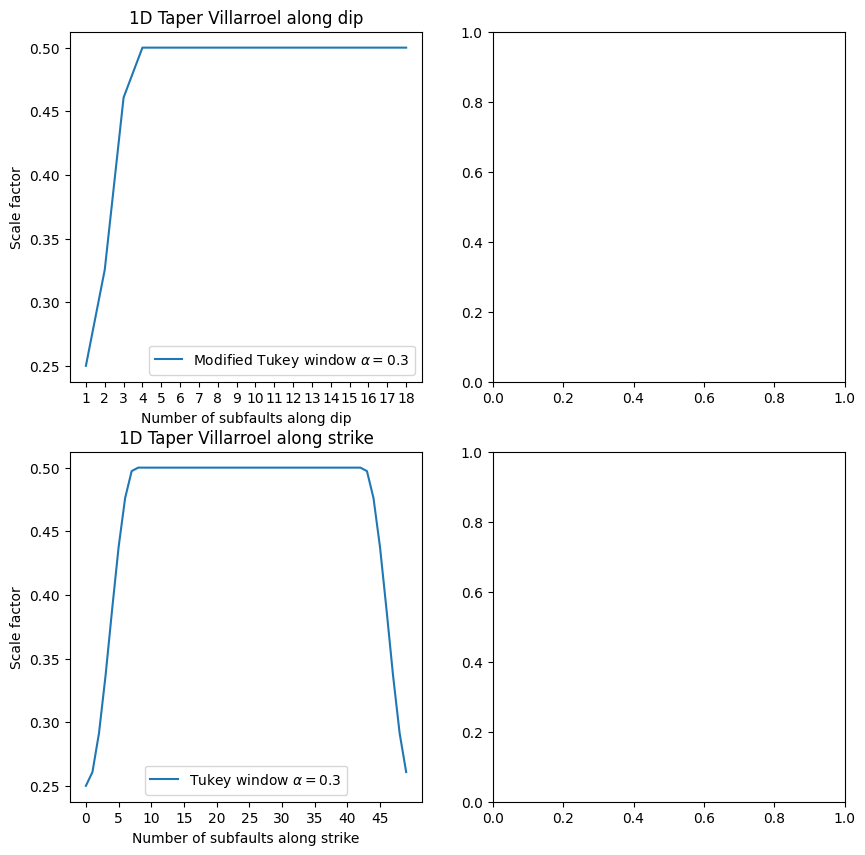

In [9]:
fig, axs = plt.subplots(2, 2,figsize=(10,10))
nxx=np.arange(nx)
nyy=np.arange(ny)
villarroel_taper=geostochpy.taper_except_trench_tukey(dep,alpha_dip=0.3,alpha_strike=0.3)
axs[0,0].plot(nxx,villarroel_taper[0,:],label=r'Modified Tukey window $\alpha=0.3$')
axs[0,0].set_xlabel('Number of subfaults along dip')
axs[0,0].set_ylabel('Scale factor')
axs[0,0].set_title('1D Taper Villarroel along dip')
axs[0,0].legend()
axs[0,0].set_xticks(range(len(X_grid[0])), range(1, len(X_grid[0]) + 1))
#
axs[1,0].plot(nyy,villarroel_taper[:,0],label=r'Tukey window $\alpha=0.3$')
axs[1,0].set_xlabel('Number of subfaults along strike')
axs[1,0].set_ylabel('Scale factor')
axs[1,0].set_title('1D Taper Villarroel along strike')
axs[1,0].legend()
axs[1,0].set_xticks(np.arange(0, 49, step=5))

# ax_big = axs[0, 1].twiny()
# im2=ax_big.imshow(villarroel_taper)
# ax_big.set_title('2D Taper Villarroel')
# ax_big.set_xlabel('Subfault number along dip')
# ax_big.set_ylabel('Subfault number along strike')

# # add space for colour bar
# cbar_ax = fig.add_axes([0.88, 0.15, 0.04, 0.7])
# fig.colorbar(im2, cax=cbar_ax,label='Scale factor')

plt.show()

In [18]:
import numpy as np
from scipy.interpolate import griddata
route_file=geostochpy.get_data('median_lock_Herrera2023.txt')
route_file_mesh=geostochpy.get_data('mesh__Herrera2023.npy')
mesh=np.load(route_file_mesh,allow_pickle=True)
median_lock=np.loadtxt(route_file)
mesh1=mesh[0]
x=mesh1[:,0]
y=mesh1[:,1]
z=median_lock
taper_coupling = griddata((x, y), z, (X_grid, Y_grid), method='linear', fill_value=0, rescale=True)
print(taper_coupling)

[[0.17410152 0.2024824  0.2302981  0.25356759 0.27230002 0.28582223
  0.29642889 0.29644565 0.28834436 0.27452006 0.24376032 0.21370303
  0.14918448 0.07114862 0.01553283 0.         0.         0.        ]
 [0.1585349  0.18554218 0.20969108 0.23069184 0.24838744 0.26557755
  0.27746432 0.27568029 0.26868418 0.25492396 0.22378796 0.19876505
  0.14355544 0.02907462 0.         0.         0.         0.        ]
 [0.14460295 0.171765   0.1931319  0.21135304 0.23020605 0.24688414
  0.25974627 0.26042909 0.25135883 0.24013227 0.21538153 0.18244299
  0.14731362 0.04508945 0.         0.         0.         0.        ]
 [0.07763642 0.15550958 0.17535014 0.19148958 0.20928034 0.22334347
  0.23523607 0.23790976 0.23451501 0.22512463 0.20175199 0.15544608
  0.13422795 0.0604825  0.         0.         0.         0.        ]
 [0.01221242 0.12447348 0.15745727 0.17525703 0.18927219 0.19856932
  0.20392882 0.20713235 0.20727955 0.20303892 0.18449244 0.13360556
  0.08100094 0.06936352 0.         0.       

/home/alex/miniforge3/envs/geostochpy/lib/python3.11/site-packages/geostochpy-0.1-py3.11.egg/geostochpy/__init__.py:699: RuntimeWarning: invalid value encountered in multiply
  return (r ** H) * kv(H, r)


0.009644528559821248 vs 7.942299656634822


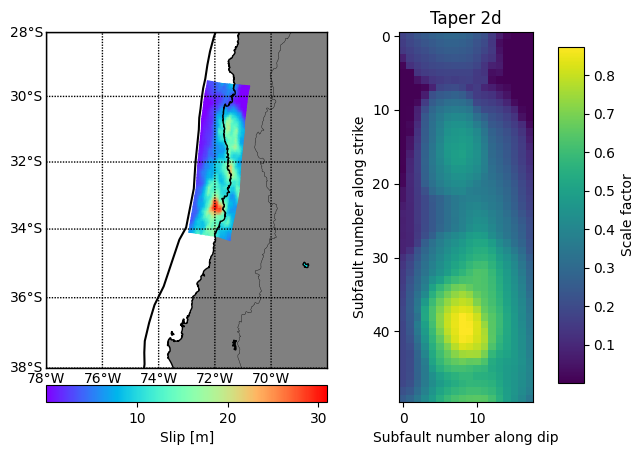

In [63]:

## Creation slip models
# mean matrix
#
media,rigidez_media=geostochpy.media_slip(Mw,dy_meters,dx_meters,dep)
leveque_taper=geostochpy.taper_LeVeque(dep,60000)
# leveque_taper=leveque_taper/np.max(leveque_taper)
villarroel_taper=geostochpy.taper_except_trench_tukey(dep,alpha_dip=0.3,alpha_strike=0.3)
taper=leveque_taper*villarroel_taper
# taper=geostochpy.taper_except_trench_tukey(dep,alpha_dip=0.6,alpha_strike=0.4,dip_taperfunc=geostochpy.taper_LeVeque,strike_taperfunc=geostochpy.tukey_window_equal)

mu = geostochpy.matriz_medias_villarroel(media,taper_coupling)
# matriz de covarianza
C    = geostochpy.matriz_covarianza_von_karman(dip, dep, X_grid, Y_grid,length,width)
# for comcot simulation
Slip=geostochpy.distribucion_slip(C, mu, 899)
Slip,rigidez,Mo_original,Mo_deseado=geostochpy.escalar_magnitud_momento(Mw, Slip, dep, dy_meters,dx_meters,prem=True) # se escala el Slip a la magnitud deseada <--------- Slip final
# Hypocenter=geostochpy.hypocenter(X_grid,Y_grid,dep,length,width) se tiene en cuenta la rigidez con el modelo PREM incluido @fetched with Rockhound
# PLOT result
fig=geostochpy.plot_slip(X_grid,Y_grid,lonsfosa,latsfosa,Slip,None,show=True)
ax2=fig.add_subplot(122)
im2=ax2.imshow(taper_coupling)
ax2.set_title('Taper 2d')
ax2.set_xlabel('Subfault number along dip')
ax2.set_ylabel('Subfault number along strike')
# add space for colour bar
fig.subplots_adjust(left=-0.5, right=1.1)
cbar_ax = fig.add_axes([0.88, 0.15, 0.04, 0.7])
print(f'{media} vs {np.mean(Slip)}')
fig.colorbar(im2, cax=cbar_ax,label='Scale factor')

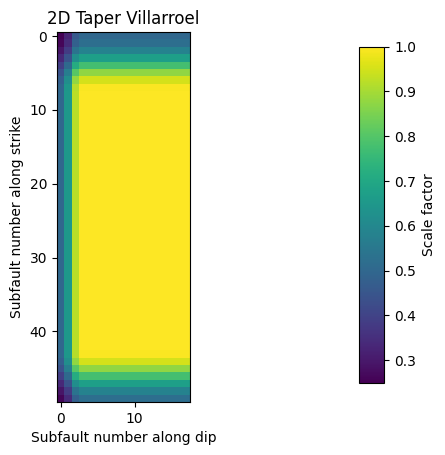

In [28]:
fig, ax = plt.subplots()

im2 = ax.imshow(villarroel_taper)
ax.set_title('2D Taper Villarroel')
ax.set_xlabel('Subfault number along dip')
ax.set_ylabel('Subfault number along strike')

# add space for colour bar
cbar_ax = fig.add_axes([0.88, 0.15, 0.04, 0.7])
fig.colorbar(im2, cax=cbar_ax, label='Scale factor')

plt.show()

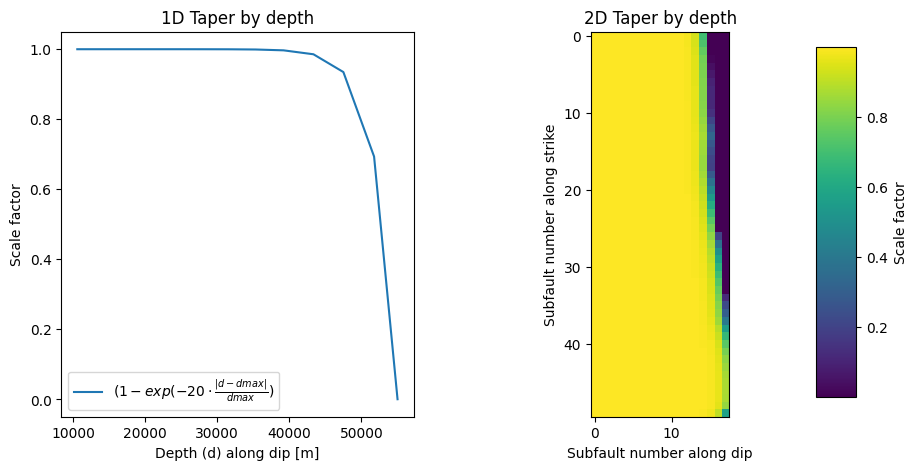

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

leveque_taper=geostochpy.taper_LeVeque(dep,55000)
ax1.plot(dep[0,:],leveque_taper[0,:],label=r'$(1 - exp( -20\cdot\frac{| d - dmax |}{dmax} )$')
ax1.set_xlabel('Depth (d) along dip [m]')
ax1.set_ylabel('Scale factor')
ax1.set_title('1D Taper by depth')
ax1.legend()

im2=ax2.imshow(leveque_taper)
ax2.set_title('2D Taper by depth')
ax2.set_xlabel('Subfault number along dip')
ax2.set_ylabel('Subfault number along strike')

# add space for colour bar
cbar_ax = fig.add_axes([0.88, 0.15, 0.04, 0.7])
fig.colorbar(im2, cax=cbar_ax,label='Scale factor')

plt.show()

In [65]:
C    = geostochpy.matriz_covarianza_von_karman(dip, dep, X_grid, Y_grid,length,width)
# for comcot simulation
Slip=geostochpy.distribucion_slip(C, mu, 899)

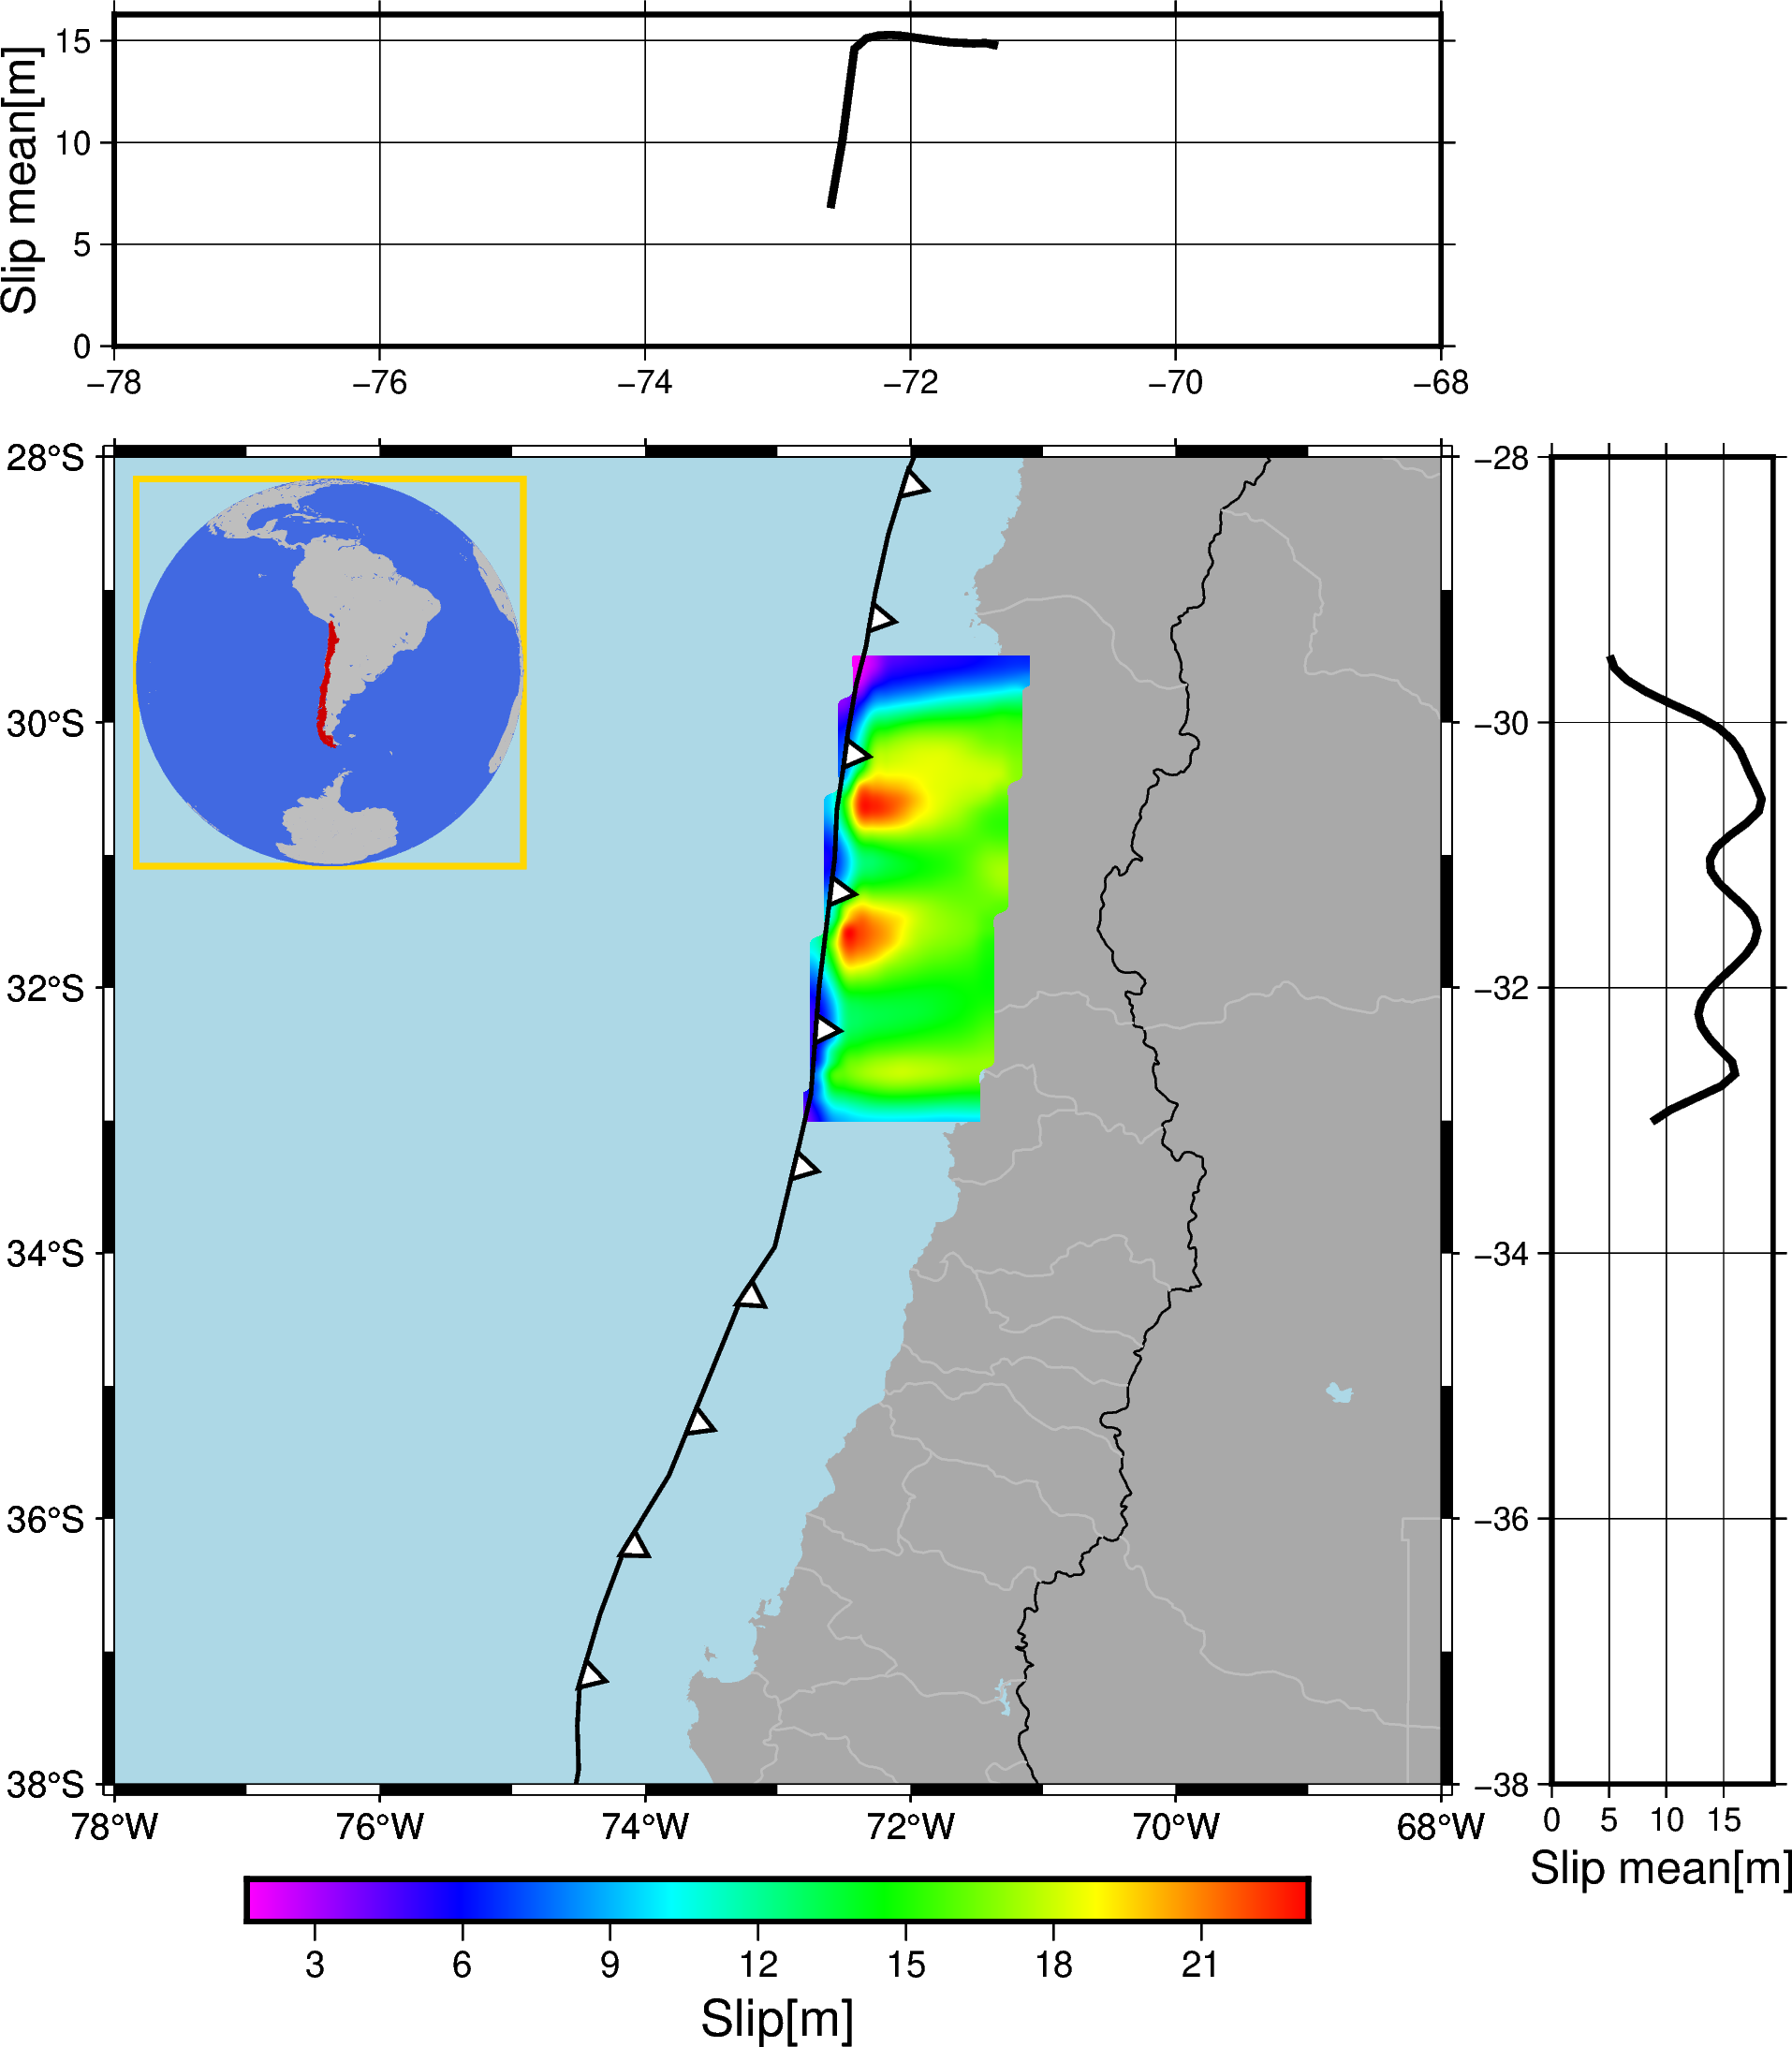

In [ ]:
geostochpy.plot_slip_gmt([-78,-68,-38,-28],X_grid,Y_grid,lons_fosa,lats_fosa,Slip,10,10)

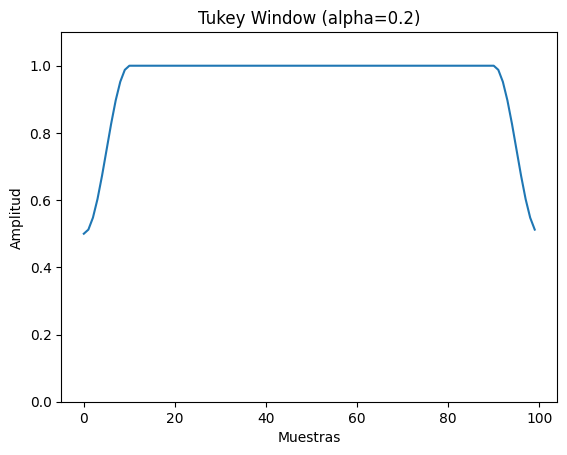

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def tukey_window_equal(N, alpha=0.5):
    """
    Genera una ventana Tukey.Se ha
    ajustado los valores de la parte de Hann para que no alcancen completamente cero al comienzo

    Parámetros:
    - N: Longitud de la ventana.
    - alpha: Parámetro de apertura (0 para una ventana rectangular, 1 para una ventana Hann).

    Retorna:
    - Ventana Tukey.
    """
    if alpha <= 0:
        return np.ones(N)
    elif alpha >= 1:
        return np.hanning(N)
    else:
        
        x = np.linspace(0, 1, N, endpoint=False)
        w = np.ones_like(x)

        # Aplica la parte de la ventana Hann
        first_condition = x < alpha / 2
        last_condition = x >= 1 - alpha / 2

        w[first_condition] = 0.5 * (1 + np.cos(2 * np.pi / alpha * (x[first_condition] - alpha / 2)))
        w[last_condition] = 0.5 * (1 + np.cos(2 * np.pi / alpha * (x[last_condition] - 1 + alpha / 2)))

        # Ajusta los valores para que no alcancen completamente cero al comienzo y al final
        w[first_condition] = 0.5 + 0.5 * w[first_condition]
        w[last_condition] = 0.5 + 0.5 * w[last_condition]

        return w
# Ejemplo de uso
N = 100
alpha = 0.2
tukey = tukey_window_equal(N, alpha)

# Visualización de la ventana Tukey
plt.plot(tukey)
plt.title(f'Tukey Window (alpha={alpha})')
plt.xlabel('Muestras')
plt.ylabel('Amplitud')
plt.ylim(top=1.1,bottom=0)
plt.show()


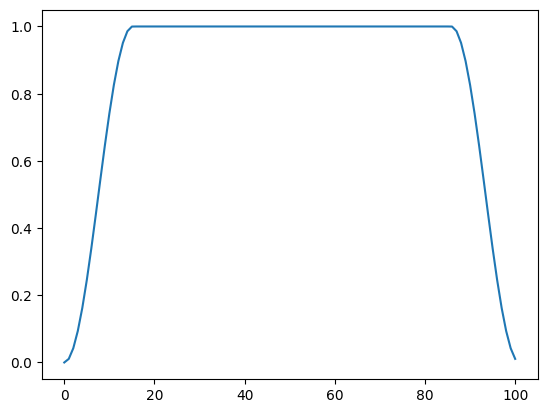

In [ ]:
import scipy
window=scipy.signal.windows.tukey(101, alpha=0.3, sym=False)
plt.plot(window)